## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [1]:
from google.colab import files

uploaded = files.upload()

Saving habr_texts.txt to habr_texts.txt


### Установка BigARTM
Все точно как в инструкции на их сайте, только без установки питона и пипа.

In [0]:
!apt-get --yes install git make cmake build-essential libboost-all-dev

In [0]:
!pip install protobuf tqdm wheel

In [0]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

In [0]:
cd bigartm

In [0]:
mkdir build

In [0]:
cd build

In [0]:
!cmake ..

In [0]:
!make

In [0]:
!pip install python/bigartm*.whl -U

Вернемся в изначальную папку.

In [0]:
cd ../.. 

In [0]:
!pip install pymorphy2[fast] nltk gensim

In [13]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def clear_text(text):
    fin_text = []
    for word in text:
        if is_number(word):
          fin_text.append('NUMBER')
          continue
        if len(word) == 1:
          if word.isalpha():
              fin_text.append('VARIABLE')
          continue
        if re.search('[^a-zа-я\-.0-9_]', word) is not None:
          continue
        fin_text.append(word)
    return fin_text

def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
    return clean

<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<input>:18: DeprecationWarning: invalid escape sequence \-
<ipython-input-15-fbead1224e3a>:18: DeprecationWarning: invalid escape sequence \-
  if re.search('[^a-zа-я\-.0-9_]', word) is not None:


## Возьмем теже данные

In [0]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/habr_texts.txt.zip

In [17]:
!unzip habr_texts.txt.zip

Archive:  habr_texts.txt.zip
replace habr_texts.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: habr_texts.txt          


In [0]:
habr_texts = [clear_text(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt')]

In [24]:
nltk.download('stopwords')
# вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
p = gensim.models.phrases.Phraser(ph)
habr_texts = p[habr_texts]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# p[habr_texts[1]]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [0]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [0]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [0]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [30]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=92c34db9-794a-416f-80c4-c889f29e8cd3, num_entries=34380)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [0]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [0]:
counts = [50,100,150,200,250,300]
models = {}
for c in counts:


  model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(c)],
                       
                        regularizers=[
                            artm.DecorrelatorPhiRegularizer(
                                              name='Decorr', tau=0.25, 
                                              class_ids=['@default_class'],
                                              topic_names=['topic_{}'.format(i) for i in range(0, c)]),
                           
                            artm.SmoothSparsePhiRegularizer(
                                              name='SmoothPhi_1', 
                                              class_ids=['@default_class'],
                                              tau=0.15, 
                                              topic_names=['topic_{}'.format(i) for i in range(0, c)])
                                      ]
                          )
  model.initialize(dictionary=dictionary, )
  # добавляем метрики
  model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
  model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
  model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
  model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
  model.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 
  model.num_document_passes = 2
  models[c] = model

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


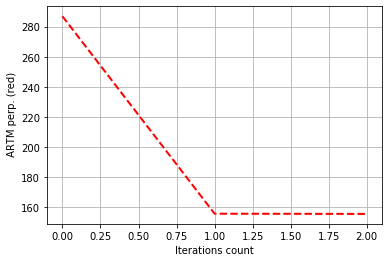

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.006 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 157.048 (ARTM)


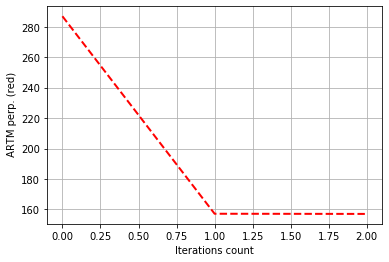

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.002 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 158.700 (ARTM)


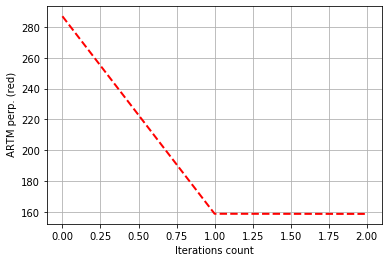

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 160.457 (ARTM)


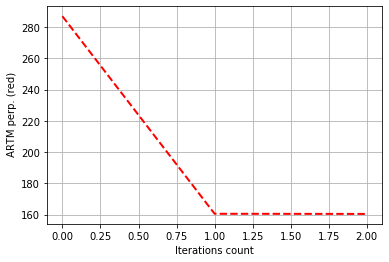

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 162.254 (ARTM)


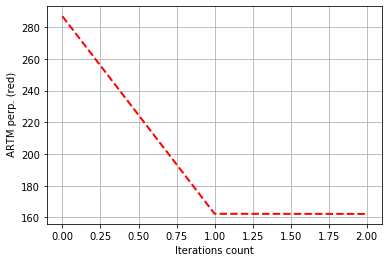

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 164.042 (ARTM)


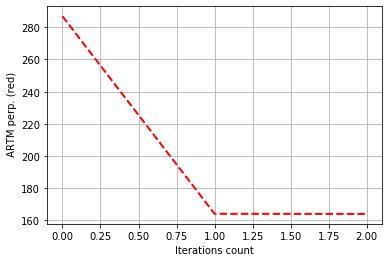

In [47]:
for key in models:
  model = models[key]
  model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)
  print_measures(model)

In [0]:
taus = [0.1,0.2,0.4,0.6,0.8,1]
models = {}
for tau in taus:


  model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],
                       
                        regularizers=[
                            artm.DecorrelatorPhiRegularizer(
                                              name='Decorr', tau=tau, 
                                              class_ids=['@default_class'],
                                              topic_names=['topic_{}'.format(i) for i in range(0, 50)]),
                           
                            artm.SmoothSparsePhiRegularizer(
                                              name='SmoothPhi_1', 
                                              class_ids=['@default_class'],
                                              tau=0.15, 
                                              topic_names=['topic_{}'.format(i) for i in range(0, 50)])
                                      ]
                          )
  model.initialize(dictionary=dictionary, )
  # добавляем метрики
  model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
  model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
  model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
  model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
  model.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 
  model.num_document_passes = 2
  models[tau] = model

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


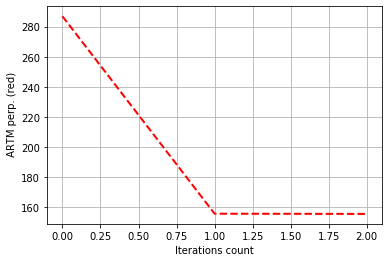

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


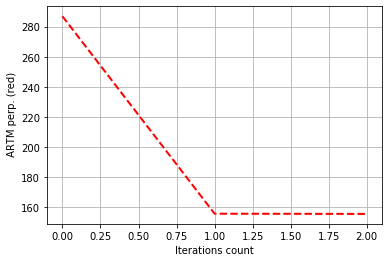

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


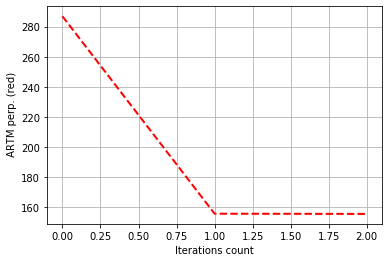

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


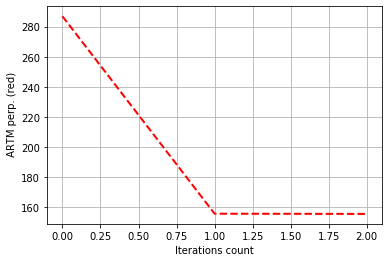

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


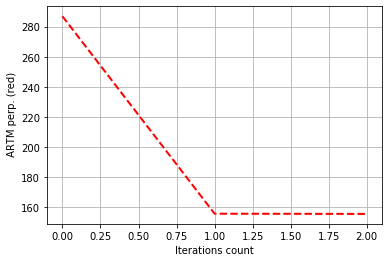

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


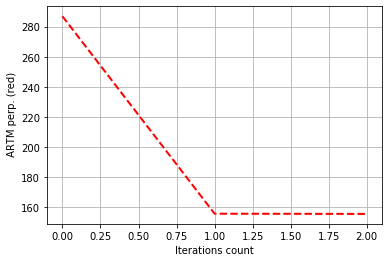

In [55]:
for key in models:
  model = models[key]
  model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)
  print_measures(model)

In [0]:
taus = [-0.5,-0.3,-0.15,0,0.15,0.3,0.5]
models = {}
for tau in taus:


  model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],
                       
                        regularizers=[
                            artm.DecorrelatorPhiRegularizer(
                                              name='Decorr', tau=0.25, 
                                              class_ids=['@default_class'],
                                              topic_names=['topic_{}'.format(i) for i in range(0, 50)]),
                           
                            artm.SmoothSparsePhiRegularizer(
                                              name='SmoothPhi_1', 
                                              class_ids=['@default_class'],
                                              tau=tau, 
                                              topic_names=['topic_{}'.format(i) for i in range(0, 50)])
                                      ]
                          )
  model.initialize(dictionary=dictionary, )
  # добавляем метрики
  model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
  model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
  model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
  model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
  model.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 
  model.num_document_passes = 2
  models[tau] = model

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

Sparsity Phi: 0.644 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.180 (ARTM)
Kernel purity: 0.069 (ARTM)
Perplexity: 155.001 (ARTM)


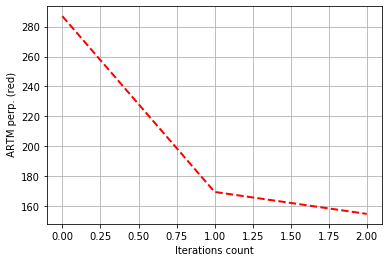

Sparsity Phi: 0.493 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.138 (ARTM)
Kernel purity: 0.030 (ARTM)
Perplexity: 155.796 (ARTM)


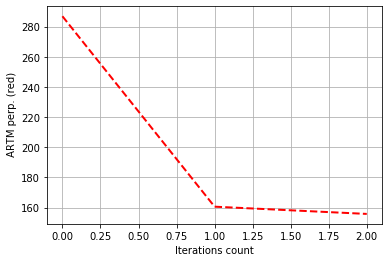

Sparsity Phi: 0.324 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.112 (ARTM)
Kernel purity: 0.003 (ARTM)
Perplexity: 155.372 (ARTM)


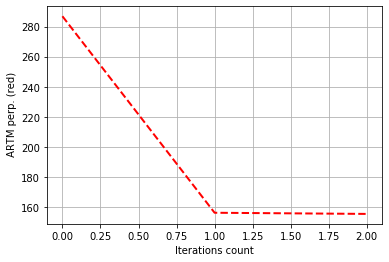

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.025 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 154.928 (ARTM)


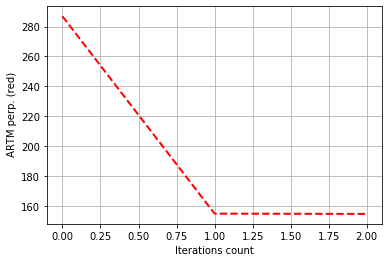

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.020 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 155.646 (ARTM)


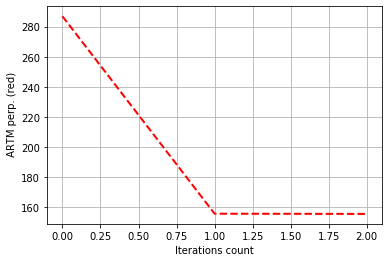

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.019 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 157.025 (ARTM)


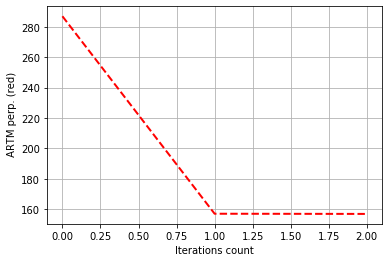

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.016 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 159.258 (ARTM)


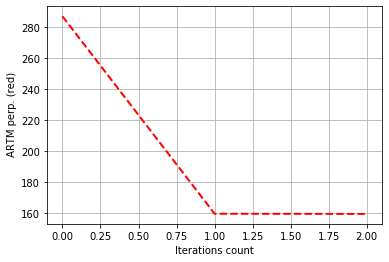

In [80]:
for key in models:
  model = models[key]
  model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)
  print_measures(model)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [0]:
model_artm = models[-0.5]

Sparsity Phi: 0.644 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.180 (ARTM)
Kernel purity: 0.069 (ARTM)
Perplexity: 155.001 (ARTM)


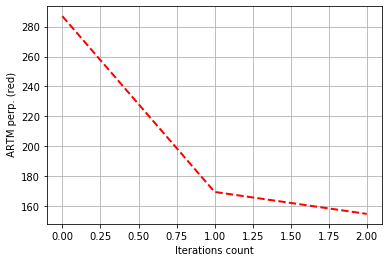

In [86]:
print_measures(model_artm)

In [0]:
taus = [-0.3, -0.15, 0, 0.15, 0.3]
models = {}
for tau in taus:
  model = model_artm.clone()

  model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ), overwrite=True)
  model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]), overwrite=True)
  models[tau] = model

Sparsity Phi: 0.925 ARTM)
Sparsity Theta: 0.027 (ARTM)
Kernel contrast: 0.470 (ARTM)
Kernel purity: 0.610 (ARTM)
Perplexity: 127.293 (ARTM)


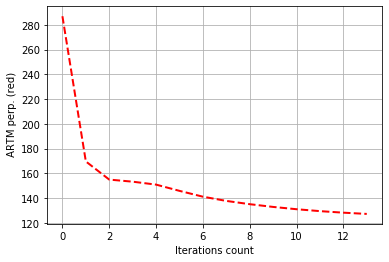

Sparsity Phi: 0.913 ARTM)
Sparsity Theta: 0.025 (ARTM)
Kernel contrast: 0.438 (ARTM)
Kernel purity: 0.581 (ARTM)
Perplexity: 127.216 (ARTM)


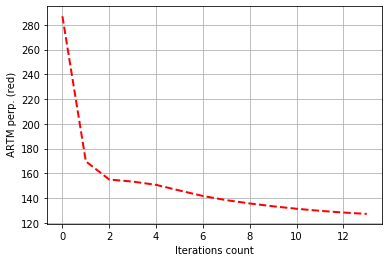

Sparsity Phi: 0.895 ARTM)
Sparsity Theta: 0.022 (ARTM)
Kernel contrast: 0.402 (ARTM)
Kernel purity: 0.543 (ARTM)
Perplexity: 127.249 (ARTM)


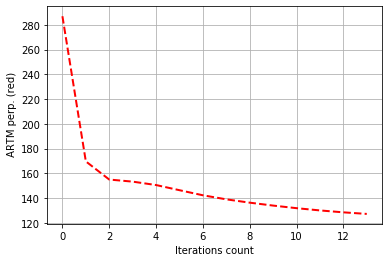

Sparsity Phi: 0.862 ARTM)
Sparsity Theta: 0.019 (ARTM)
Kernel contrast: 0.362 (ARTM)
Kernel purity: 0.494 (ARTM)
Perplexity: 127.515 (ARTM)


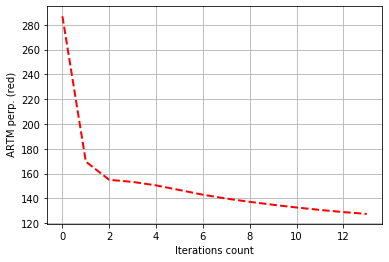

Sparsity Phi: 0.774 ARTM)
Sparsity Theta: 0.014 (ARTM)
Kernel contrast: 0.314 (ARTM)
Kernel purity: 0.416 (ARTM)
Perplexity: 128.455 (ARTM)


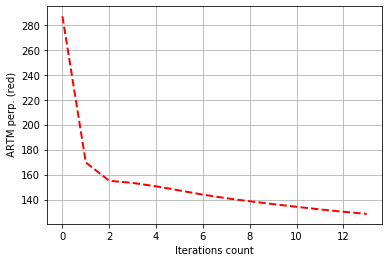

In [88]:
for key in models:
  model = models[key]
  model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
  # будем постепенно увеличивать значения этих регуляризаторов
  phi_tau = model.regularizers['SparsePhi'].tau
  theta_tau = model.regularizers['SparseTheta'].tau

  for i in range(10):
      model.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
      model.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
      model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
  print_measures(model)

Sparsity Phi: 0.914 ARTM)
Sparsity Theta: 0.047 (ARTM)
Kernel contrast: 0.438 (ARTM)
Kernel purity: 0.583 (ARTM)
Perplexity: 126.895 (ARTM)


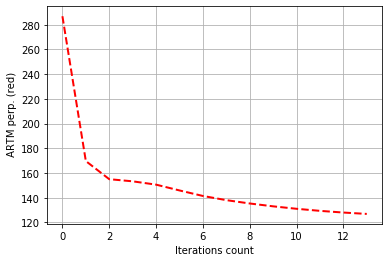

Sparsity Phi: 0.913 ARTM)
Sparsity Theta: 0.025 (ARTM)
Kernel contrast: 0.438 (ARTM)
Kernel purity: 0.581 (ARTM)
Perplexity: 127.216 (ARTM)


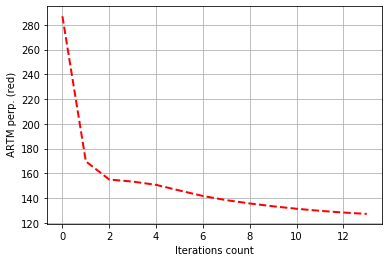

Sparsity Phi: 0.913 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.437 (ARTM)
Kernel purity: 0.579 (ARTM)
Perplexity: 127.548 (ARTM)


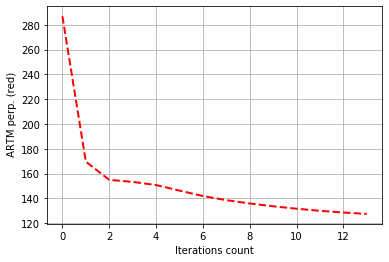

Sparsity Phi: 0.912 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.436 (ARTM)
Kernel purity: 0.576 (ARTM)
Perplexity: 127.879 (ARTM)


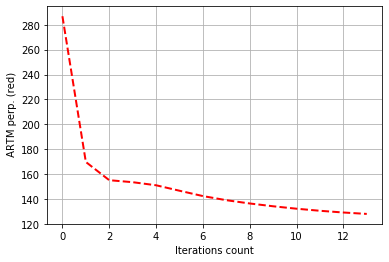

Sparsity Phi: 0.912 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.435 (ARTM)
Kernel purity: 0.574 (ARTM)
Perplexity: 128.200 (ARTM)


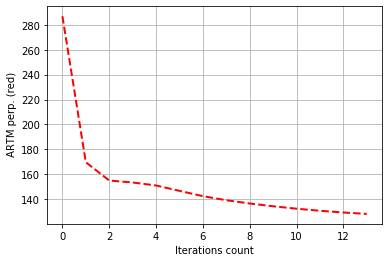

In [89]:
taus = [-0.3, -0.15, 0, 0.15, 0.3]
models = {}
for tau in taus:
  model = model_artm.clone()

  model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ), overwrite=True)
  model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=tau, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]), overwrite=True)
  models[tau] = model
for key in models:
  model = models[key]
  model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
  # будем постепенно увеличивать значения этих регуляризаторов
  phi_tau = model.regularizers['SparsePhi'].tau
  theta_tau = model.regularizers['SparseTheta'].tau

  for i in range(10):
      model.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
      model.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
      model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
  print_measures(model)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

Sparsity Phi: 0.914 ARTM)
Sparsity Theta: 0.047 (ARTM)
Kernel contrast: 0.438 (ARTM)
Kernel purity: 0.583 (ARTM)
Perplexity: 126.895 (ARTM)


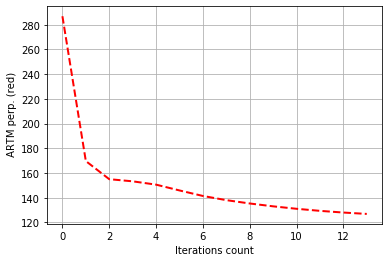

In [92]:
final = models[-0.3]
print_measures(final)

In [96]:
# посмотрим на темы
for topic_name in final.topic_names:
    if topic_name == 'topic_11' or  topic_name == 'topic_23' or  topic_name == 'topic_29':
      print(topic_name + ': ')
      try:
          for x in final.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
              print(x)
          print('---------')
    
      except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
          continue

topic_11: 
сети
через
сервера
настройки
устройства
доступа
сеть
ip
сервер
порт
---------
topic_23: 
пользователей
данных
безопасности
данные
серверов
всех
уязвимости
системы
oracle
доступ
---------
topic_29: 
алгоритм
алгоритма
точки
операций
метод
вычисления
алгоритмов
пример
вектор
числа
---------


Получение наилучшей модели:
- количество тем - лучшая перплексия при 50
- тау декоррелятора - оставил 0.25 т.к. ничего не менялось
- тау сглаживателя - -0.5, график становится более гладким
- количество проходов - если брать больше 3 перплексия начинает расти
- тау для разреженности тем - -0.15 т.к. наилучшая перплексия
- тау для разреженности документов - -0.3 т.к. лучшая перплексия